In [40]:
%pip install z3-solver
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 7.7 MB/s  0:00:01 eta 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 8.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 5.7 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [1]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt
s = Solver()

In [2]:
# Constants
chip_size = (30, 30)
component_sizes =  [[4,5],
                    [4,6],
                    [5,20],
                    [6,9],
                    [6,10],
                    [6,11],
                    [7,8],
                    [7,12],
                    [10,10],
                    [10,20]]
power_component_size = (4,3)
min_distance_power_components = 16

In [3]:
# Init variables respresenting start x and y of the power components and their orientation
power0_x = Int("power0_x")
power0_y = Int("power0_y")
power0_is_vertical = Bool("power0_is_vertical")

power1_x = Int("power1_x")
power1_y = Int("power1_y")
power1_is_vertical = Bool("power1_is_vertical")

In [4]:
# Init variables for every other component
xyb = []
for idx, size in enumerate(component_sizes):
    comp_x = Int(f"comp{idx}_x")
    comp_y = Int(f"comp{idx}_y")
    comp_is_vertical = Bool(f"comp{idx}_is_vertical")
    xyb.append((comp_x, comp_y, comp_is_vertical))

In [5]:
# Add positivity constraints
s.add(power0_x >= 0, power0_y >= 0)
s.add(power1_x >= 0, power1_y >= 0)
for comp_x, comp_y, _ in xyb:
    s.add(comp_x >= 0, comp_y >= 0)

In [7]:
# Make sure components fit withing chip boundaries
s.add(And(power0_is_vertical == And(    power0_x + power_component_size[0] < 30,
                                        power0_y + power_component_size[1] < 30),
        Not(power0_is_vertical) == And( power0_x + power_component_size[1] < 30,
                                        power0_y + power_component_size[0] < 30)))

s.add(And(power1_is_vertical == And(    power1_x + power_component_size[0] < 30,
                                        power1_y + power_component_size[1] < 30),
        Not(power1_is_vertical) == And( power1_x + power_component_size[1] < 30,
                                        power1_y + power_component_size[0] < 30)))
for idx, packed_values in enumerate(xyb):
    comp_x, comp_y, comp_is_vertical = packed_values
    s.add(And(comp_is_vertical == And(  comp_x + component_sizes[idx][0] < 30,
                                        comp_y + component_sizes[idx][1] < 30),
        Not(power1_is_vertical) == And( comp_x + component_sizes[idx][1] < 30,
                                        comp_y + component_sizes[idx][0] < 30)))

In [ ]:
# Adding constraints s.t. no component overlays another


In [8]:
s.check()
s.model()

[comp6_is_vertical = True,
 comp1_y = 0,
 power0_x = 26,
 comp7_is_vertical = True,
 comp0_is_vertical = True,
 comp9_y = 0,
 comp6_y = 0,
 comp8_x = 0,
 comp2_y = 0,
 comp8_is_vertical = True,
 comp1_is_vertical = True,
 comp7_y = 0,
 comp8_y = 0,
 power0_y = 0,
 comp9_is_vertical = True,
 comp2_is_vertical = True,
 comp3_y = 0,
 comp9_x = 0,
 comp0_y = 0,
 comp1_x = 0,
 comp3_is_vertical = True,
 power1_y = 0,
 comp5_x = 0,
 comp7_x = 0,
 comp4_is_vertical = True,
 power1_x = 26,
 comp3_x = 0,
 comp4_x = 0,
 comp6_x = 0,
 comp5_is_vertical = True,
 comp0_x = 0,
 comp2_x = 0,
 comp5_y = 0,
 comp4_y = 0,
 power0_is_vertical = False,
 power1_is_vertical = False]

In [136]:
model = s.model()

# Visualizing the result

In [137]:
cmap = plt.get_cmap("Set3", 12)

labels = {
    0: "Unassigned",
    1: "Component 1",
    2: "Component 2",
    3: "Component 3",
    4: "Component 4",
    5: "Component 5",
    6: "Component 6",
    7: "Component 7",
    8: "Component 8",
    9: "Component 9",
    10: "Component 10",
    11: "Power Component"
}

def map_key2scale(key):
    return (key+0.5) * 10/12


In [146]:
def visualize_result(model):
    image_grid = np.array([
        [int(model[element].as_long()) for element in row]
        for row in x
    ])
    image_grid = np.random.randint(0,11,[30,30])
    print(image_grid[0])
    fig, ax = plt.subplots()
    im = ax.imshow(image_grid, cmap="Paired")
    ax.axis("off")

    cbar = fig.colorbar(im, ax=ax, ticks=[map_key2scale(key) for key in labels.keys()])
    cbar.ax.set_yticklabels(list(labels.values()))
    plt.show() 

[ 2  3  1  8 10  6  2  6  6 10  5  3  7  9  6  4  7  0  3  7  8  8  7  1
  9 10  3  9  7 10]


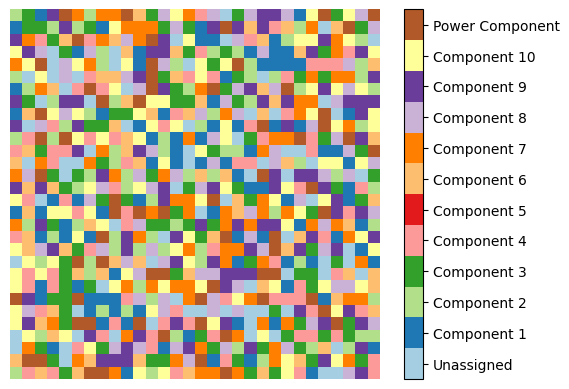

In [147]:
visualize_result(model)